# AutoML Tutorial - DRAFT

<div class="alert alert-block alert-info"><span style="color:black">
In this tutorial, we will use a subset of the loan-level data from Fannie Mae and Freddie Mac. Firstly, we will solve a binary classification problem (predicting if a loan is delinquent or not). Then, we will explore a regression use-case (predicting interest rates on the same dataset).
</span></div>

<div class="alert alert-block alert-danger"><span style="color:black">
Please note that this work in progress. The complete tutorial will be available soon.
    </span></div>

## Initial Setup

In [1]:
#Import H2O and other libaries that will be used in this tutorial 
import h2o
import matplotlib as plt
import pandas as pd
%matplotlib inline
from h2o.automl import H2OAutoML

In [2]:
h2o.init(max_mem_size="4G")

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,2 hours 45 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,2 months and 5 days
H2O cluster name:,H2O_from_python_falvarenga_urcsol
H2O cluster total nodes:,1
H2O cluster free memory:,3.957 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


### Import the dataset and explore the output responses

In [3]:
#Import the dataset 
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/H2O-3-Tutorials/loan_level_50k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE
730,199903,N,202902,16620,30,1,O,94,29,138000,94,7,T,N,FRM,WV,SF,25300,F199Q1000037,P,360,2,Other sellers,Other servicers,TRUE,FALSE
638,199905,N,202904,42020,nan,1,O,67,28,160000,67,7.375,T,N,FRM,CA,SF,93400,F199Q1000067,N,360,2,CROSSLAND MORTGAGE C,CHASEMTGECO,TRUE,FALSE
577,199903,N,202902,12580,12,1,O,80,53,43000,80,7.25,T,N,FRM,MD,SF,21200,F199Q1000086,N,360,1,ACCUBANC MORTGAGE CO,GMACMTGECORP,FALSE,TRUE
693,199905,N,202904,nan,nan,1,O,80,43,93000,80,7.125,R,N,FRM,SD,SF,57500,F199Q1000104,P,360,1,"NORWEST MORTGAGE, IN",WELLSFARGOHOMEMORTGA,TRUE,FALSE
739,199905,,202904,16700,nan,1,S,80,25,200000,80,6.875,R,N,FRM,SC,CO,29400,F199Q1000107,P,360,2,"NORWEST MORTGAGE, IN",WELLSFARGOHOMEMORTGA,TRUE,FALSE
695,199905,,202904,42044,0,1,O,40,6,135000,40,6.875,R,N,FRM,CA,SF,92800,F199Q1000121,C,360,2,NATIONSBANC MORTGAGE,"BAMORTGAGE,LLC",TRUE,FALSE
753,199905,N,202904,41740,0,1,O,80,17,59000,80,7,R,N,FRM,CA,CO,92000,F199Q1000122,P,360,1,NATIONSBANC MORTGAGE,"BAMORTGAGE,LLC",TRUE,FALSE
712,199905,,202904,nan,nan,1,O,80,28,126000,80,7.125,R,N,FRM,MI,SF,48800,F199Q1000123,N,360,2,Other sellers,Other servicers,TRUE,FALSE


In [5]:
# Check the distribution of the response column for the Classification problem
loan_level["DELINQUENT"].table()

DELINQUENT,Count
FALSE,48118
TRUE,1812


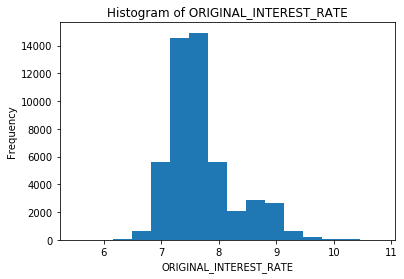

In [6]:
# Check the distribution of the response column for the Regression problem
loan_level["ORIGINAL_INTEREST_RATE"].hist()

In [7]:
# Split the dataset into training and testing, and print their distribution
train, test = loan_level.split_frame([0.8], seed=42)
print("train:%d test:%d" % (train.nrows, test.nrows))

train:39984 test:9946


In [8]:
# Choose the response column, and the predictors. 

y = "DELINQUENT"
ignore = ["PREPAID", "PREPAYMENT_PENALTY_MORTGAGE_FLAG", "PRODUCT_TYPE"] 
x = list(set(train.names) - set(ignore))

<div class="alert alert-block alert-success"><span style="color:black">
We are ignoring "PREPAID" and "PREPAYMENT_PENALTY_MORTGAGE_FLAG" because they are clear indicators that a loan has been fully paid or not. And "PRODUCT TYPE" is a constant column, so it will not help our model
    </span></div>

## Run AutoML for our Classification use case 

<div class="alert alert-block alert-success"><span style="color:black">
     We will run AutoML for 5 minutes(300 seconds). You can change this by increasing or decreasing "max_runtime_secs"
</span></div>


In [10]:
aml = H2OAutoML(max_runtime_secs=300, seed=42, project_name='classification')
%time aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 1.45 s, sys: 255 ms, total: 1.71 s
Wall time: 5min 7s


In [12]:
# Print the leaderboard, sorted by best AUC(default)
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_3_AutoML_20191029_170451,0.855035,0.119394,0.326631,0.174114,0.0303157
StackedEnsemble_AllModels_AutoML_20191029_170451,0.853866,0.127497,0.324102,0.177296,0.0314339
StackedEnsemble_BestOfFamily_AutoML_20191029_170451,0.853586,0.127474,0.32373,0.177277,0.031427
XGBoost_2_AutoML_20191029_170451,0.852738,0.120314,0.327282,0.174782,0.0305487
XGBoost_1_AutoML_20191029_170451,0.851199,0.120396,0.349517,0.174607,0.0304876
GLM_grid_1_AutoML_20191029_170451_model_1,0.845777,0.124852,0.311109,0.177708,0.03158
GBM_1_AutoML_20191029_170451,0.844156,0.126566,0.327512,0.179137,0.0320902
GBM_2_AutoML_20191029_170451,0.837406,0.126455,0.319861,0.177896,0.0316471
DRF_1_AutoML_20191029_170451,0.815392,0.182803,0.338045,0.176634,0.0311995


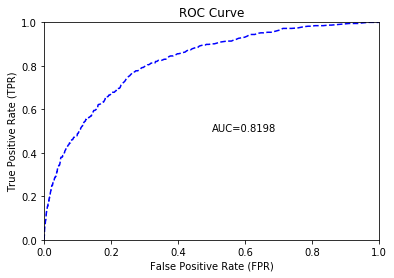


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.03438290506270764
RMSE: 0.18542627932067138
LogLoss: 0.13746220950407384
Mean Per-Class Error: 0.24741792561982368
AUC: 0.819788238755568
pr_auc: 0.2151676060611577
Gini: 0.6395764775111361

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12654804777015338: 

,,FALSE,TRUE,Error,Rate
0,FALSE,9068.0,483.0,0.0506,(483.0/9551.0)
1,TRUE,245.0,150.0,0.6203,(245.0/395.0)
2,Total,9313.0,633.0,0.0732,(728.0/9946.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.126548,0.291829,179.0
1,max f2,0.066410,0.366216,246.0
2,max f0point5,0.274999,0.300493,83.0
3,max accuracy,0.465876,0.960989,25.0
4,max precision,0.619336,0.666667,7.0
5,max recall,0.001889,1.000000,396.0
6,max specificity,0.819496,0.999895,0.0
7,max absolute_mcc,0.126548,0.263333,179.0
8,max min_per_class_accuracy,0.034738,0.746937,299.0
9,max mean_per_class_accuracy,0.032526,0.752582,304.0



Gains/Lift Table: Avg response rate:  3.97 %, avg score:  3.61 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010054,0.343128,10.827291,10.827291,0.430000,0.447115,0.430000,0.447115,0.108861,0.108861,982.729114,982.729114
1,,2,0.020008,0.252206,6.358522,8.604135,0.252525,0.284422,0.341709,0.366177,0.063291,0.172152,535.852193,760.413460
2,,3,0.030062,0.203367,6.294937,7.831828,0.250000,0.223842,0.311037,0.318573,0.063291,0.235443,529.493671,683.182761
3,,4,0.040016,0.174056,4.069454,6.895961,0.161616,0.188056,0.273869,0.286108,0.040506,0.275949,306.945403,589.596082
4,,5,0.050070,0.148770,3.776962,6.269656,0.150000,0.160299,0.248996,0.260845,0.037975,0.313924,277.696203,526.965584
5,,6,0.100040,0.091053,2.938482,4.605743,0.116700,0.114938,0.182915,0.187965,0.146835,0.460759,193.848152,360.574264
6,,7,0.150010,0.064409,2.026539,3.746584,0.080483,0.076205,0.148794,0.150737,0.101266,0.562025,102.653898,274.658431
7,,8,0.200080,0.049028,1.617976,3.213897,0.064257,0.056302,0.127638,0.127104,0.081013,0.643038,61.797570,221.389733
8,,9,0.300020,0.030505,1.342582,2.590544,0.053320,0.038774,0.102882,0.097681,0.134177,0.777215,34.258207,159.054366
9,,10,0.400060,0.019101,0.683270,2.113605,0.027136,0.024033,0.083941,0.079264,0.068354,0.845570,-31.673049,111.360529


In [13]:
%matplotlib inline
aml.leader.model_performance(test_data=test).plot() #Plot the ROC Curve
aml.leader.model_performance(test_data=test) #Print a summary of model performance on our test set

In [14]:
# Make predictions with the top model from our leaderboard
aml.predict(test)

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,FALSE,TRUE
FALSE,0.935242,0.064758
FALSE,0.988691,0.0113087
FALSE,0.995605,0.00439531
FALSE,0.933803,0.0661968
FALSE,0.978089,0.0219106
FALSE,0.994864,0.00513645
FALSE,0.996178,0.00382212
FALSE,0.997627,0.0023732
FALSE,0.996498,0.00350187
FALSE,0.993925,0.00607522


## Run AutoML for our Regression use case

In [15]:
# Choose the response variable and the predictors for the regression problem
y_reg = "ORIGINAL_INTEREST_RATE"
ignore_reg = ["ORIGINAL_INTEREST_RATE", "FIRST_PAYMENT_DATE", "MATURITY_DATE", "MORTGAGE_INSURANCE_PERCENTAGE", "PREPAYMENT_PENALTY_MORTGAGE_FLAG", "LOAN_SEQUENCE_NUMBER", "PREPAID", "DELINQUENT", "PRODUCT_TYPE"] 
x_reg = [i for i in train.names if i not in ignore_reg]

In [16]:
x_reg #print the predictors

['CREDIT_SCORE',
 'FIRST_TIME_HOMEBUYER_FLAG',
 'METROPOLITAN_STATISTICAL_AREA',
 'NUMBER_OF_UNITS',
 'OCCUPANCY_STATUS',
 'ORIGINAL_COMBINED_LOAN_TO_VALUE',
 'ORIGINAL_DEBT_TO_INCOME_RATIO',
 'ORIGINAL_UPB',
 'ORIGINAL_LOAN_TO_VALUE',
 'CHANNEL',
 'PROPERTY_STATE',
 'PROPERTY_TYPE',
 'POSTAL_CODE',
 'LOAN_PURPOSE',
 'ORIGINAL_LOAN_TERM',
 'NUMBER_OF_BORROWERS',
 'SELLER_NAME',
 'SERVICER_NAME']

<div class="alert alert-block alert-success"><span style="color:black">
  Now, instead of specifying the maximum running time, we will specify a maximum number of models that we want from AutoML. We will also set the stopping metric to RMSE, as well as the sort_metric for the leaderboard.   
</span></div>

In [17]:
aml = H2OAutoML(max_models=10, seed=42, project_name='regression', stopping_metric="RMSE", sort_metric="RMSE")
%time aml.train(x=x_reg, y=y_reg, training_frame=train) 

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 1.72 s, sys: 301 ms, total: 2.02 s
Wall time: 7min 18s


In [18]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20191029_174901,0.181866,0.426458,0.181866,0.309182,0.0504587
StackedEnsemble_BestOfFamily_AutoML_20191029_174901,0.18294,0.427715,0.18294,0.310117,0.0506015
GBM_3_AutoML_20191029_174901,0.185504,0.430701,0.185504,0.312407,0.0509515
GBM_2_AutoML_20191029_174901,0.185816,0.431064,0.185816,0.313343,0.0509788
GBM_5_AutoML_20191029_174901,0.185954,0.431224,0.185954,0.313482,0.0510417
GBM_1_AutoML_20191029_174901,0.186433,0.431779,0.186433,0.313988,0.0510728
XGBoost_1_AutoML_20191029_174901,0.18753,0.433047,0.18753,0.315358,0.0512072
XGBoost_2_AutoML_20191029_174901,0.187632,0.433165,0.187632,0.314343,0.0512327
GBM_4_AutoML_20191029_174901,0.187643,0.433178,0.187643,0.314254,0.0512353
DRF_1_AutoML_20191029_174901,0.191867,0.438027,0.191867,0.316769,0.051768


<div class="alert alert-block alert-success"><span style="color:black">
     Even though an stacked ensemble was the best model, let's first retrieve the best XGBoost model
</span></div>

In [19]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the top XGBoost model
xgb = h2o.get_model([mid for mid in model_ids if "XGBoost_1" in mid][0])
xgb.params['sample_rate'] #display model sample_rate

{'default': 1.0, 'actual': 0.6}

In [20]:
xgb.params['ntrees']

{'default': 50, 'actual': 185}

In [21]:
xgb.params['max_depth']

{'default': 6, 'actual': 10}

In [22]:
xgb

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20191029_174901


Model Summary: 

,,number_of_trees
0,,185.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.14631291494077517
RMSE: 0.3825087122416628
MAE: 0.27886652581545773
RMSLE: 0.04528379081939399
Mean Residual Deviance: 0.14631291494077517

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.1875299393829221
RMSE: 0.43304727153386163
MAE: 0.3153576123900488
RMSLE: 0.051207245695484495
Mean Residual Deviance: 0.1875299393829221

Cross-Validation Metrics Summary: 

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.31535763,9.71035E-4,0.31602105,0.3159187,0.31368628,0.3153326,0.3158295
1,mean_residual_deviance,0.18752992,0.0021783994,0.18929599,0.19000812,0.18456903,0.18714395,0.1866325
2,mse,0.18752992,0.0021783994,0.18929599,0.19000812,0.18456903,0.18714395,0.1866325
3,r2,0.45027646,0.0044789384,0.44677863,0.44705567,0.45308232,0.45682126,0.44764438
4,residual_deviance,0.18752992,0.0021783994,0.18929599,0.19000812,0.18456903,0.18714395,0.1866325
5,rmse,0.4330414,0.002516325,0.4350816,0.4358992,0.429615,0.43260136,0.43200985
6,rmsle,0.05120668,2.69103E-4,0.05132234,0.051532995,0.050795536,0.051179137,0.05120339



Scoring History: 

,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2019-10-29 17:50:26,1 min 24.954 sec,0.0,6.712417,6.686958,45.056547
1,,2019-10-29 17:50:26,1 min 25.352 sec,5.0,5.205114,5.175165,27.093208
2,,2019-10-29 17:50:26,1 min 25.733 sec,10.0,4.040877,4.005116,16.328685
3,,2019-10-29 17:50:27,1 min 26.071 sec,15.0,3.143757,3.100048,9.883206
4,,2019-10-29 17:50:27,1 min 26.471 sec,20.0,2.453008,2.399689,6.017247
5,,2019-10-29 17:50:28,1 min 26.885 sec,25.0,1.922435,1.857067,3.695755
6,,2019-10-29 17:50:28,1 min 27.339 sec,30.0,1.517988,1.438038,2.304288
7,,2019-10-29 17:50:29,1 min 27.806 sec,35.0,1.211701,1.114454,1.468219
8,,2019-10-29 17:50:29,1 min 28.277 sec,40.0,0.982511,0.866197,0.965328
9,,2019-10-29 17:50:29,1 min 28.704 sec,45.0,0.812779,0.678535,0.660609



See the whole table with table.as_data_frame()

Variable Importances: 

,variable,relative_importance,scaled_importance,percentage
0,"SELLER_NAME.NORWESTMORTGAGE,INC",8240.942383,1.000000,0.177164
1,ORIGINAL_UPB,3376.266602,0.409694,0.072583
2,CREDIT_SCORE,3181.517578,0.386062,0.068396
3,POSTAL_CODE,2307.643066,0.280022,0.049610
4,ORIGINAL_DEBT_TO_INCOME_RATIO,2043.422974,0.247960,0.043929
5,ORIGINAL_LOAN_TO_VALUE,1835.531860,0.222733,0.039460
6,OCCUPANCY_STATUS.I,1754.175415,0.212861,0.037711
7,METROPOLITAN_STATISTICAL_AREA,1677.003174,0.203497,0.036052
8,LOAN_PURPOSE.P,1539.581543,0.186821,0.033098
9,ORIGINAL_COMBINED_LOAN_TO_VALUE,1530.953491,0.185774,0.032912



See the whole table with table.as_data_frame()


<div class="alert alert-block alert-success"><span style="color:black">
    Let's get the best stacked ensemble and check what is the most important model in it 
</span></div>

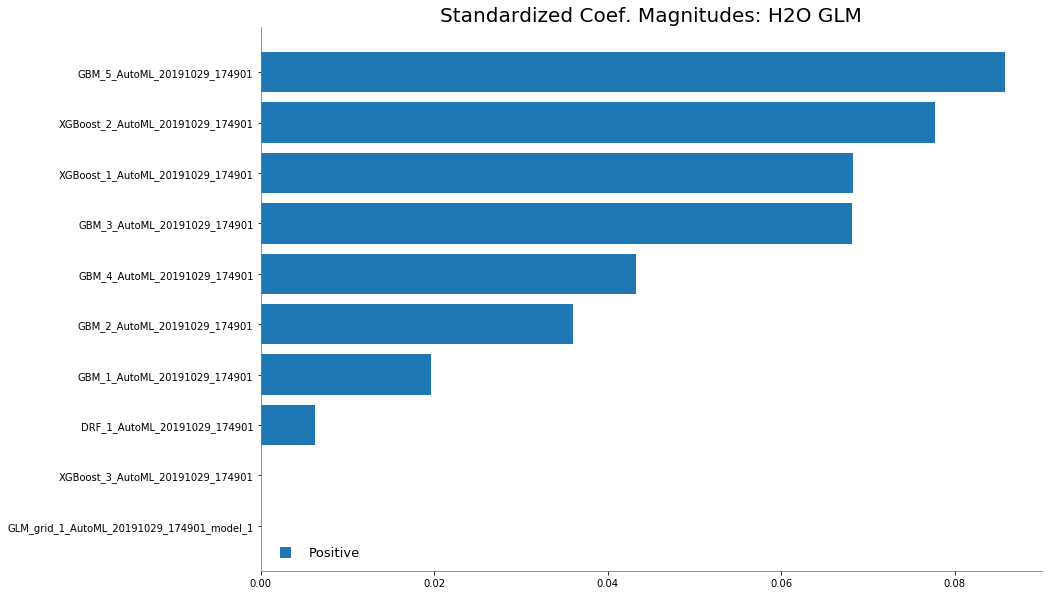

In [23]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])
%matplotlib inline
metalearner.std_coef_plot()

In [24]:
#get model performance on test set
%matplotlib inline
aml.leader.model_performance(test_data=test)


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.1795522095474
RMSE: 0.4237360139844146
MAE: 0.3091326186248081
RMSLE: 0.05017877569133409
R^2: 0.46922855284874554
Mean Residual Deviance: 0.1795522095474
Null degrees of freedom: 9945
Residual degrees of freedom: 9937
Null deviance: 3364.8269944658227
Residual deviance: 1785.8262761584406
AIC: 11165.366398561053


<div class="alert alert-block alert-success"><span style="color:black">
     Make predictions on then test set, and compare them to the actual value
</span></div>

In [25]:
pred = aml.predict(test)
pred = pred.cbind(test['ORIGINAL_INTEREST_RATE'])
pred

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,ORIGINAL_INTEREST_RATE
6.91418,7.5
7.08397,6.625
7.15397,7
7.33515,7.15
7.24323,7
7.27838,7.125
6.95294,8.75
6.85333,6.5
7.02373,7
7.18067,7.25


In [26]:
# Shutdown the H2O cluster
h2o.cluster().shutdown()

H2O session _sid_b8cc closed.
